In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import nltk
import math
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics
from sklearn.metrics import confusion_matrix


In [2]:
df = pd.read_csv('xtal_2.csv',header = None)
df.head(10)

,0,1,2
0,ATCG3D_18,DYKDDDDAMGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGI...,1
1,BSGCAIR30348,MDKKYDITAVLNEDSSMTAISDQFQITLDARPKHTAKGFGPLAALL...,1
2,BSGCAIR30512,MTESFTRRERLRLRRDFLLIFKEGKSLQNEYFVVLFRKNGLDYSRL...,1
3,BSGCAIR30561,MEHDERTHVPVELRAAGVVLLNERGDILLVQEKGIPGHPEKAGLWH...,1
4,BSGCAIR30591,MFYKEENFKKTEIGEIPEDWEIVELKDVCKKIKAGGTPKTSVEEYY...,1
5,BSGCAIR30656,MAIRLYKLAVALGVFIVSAPAFSHGHHSHGKPLTEVEQKAANGVFD...,1
6,BSGCAIR31213,MKDIDTLISNNALWSKMLVEEDPGFFEKLAQAQKPRFLWIGCSDSR...,1
7,GO.102486,GSHMQRQRPPSRAGGDMDRLQSALALYEEAMGYTYAAALRAAAAVG...,1
8,GO.102706,LDQILRATVEEVRAFLGTDRVKVYRFDPEGHGTVVAEARGGERLPS...,1
9,GO.110986,GSPDPEIFRQRFRQFGYQDSPGPREAVSQLRELCRLWLRPETHTKE...,1


In [3]:
df.columns = ['id','sequence','result']
df.head()

,id,sequence,result
0,ATCG3D_18,DYKDDDDAMGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGI...,1
1,BSGCAIR30348,MDKKYDITAVLNEDSSMTAISDQFQITLDARPKHTAKGFGPLAALL...,1
2,BSGCAIR30512,MTESFTRRERLRLRRDFLLIFKEGKSLQNEYFVVLFRKNGLDYSRL...,1
3,BSGCAIR30561,MEHDERTHVPVELRAAGVVLLNERGDILLVQEKGIPGHPEKAGLWH...,1
4,BSGCAIR30591,MFYKEENFKKTEIGEIPEDWEIVELKDVCKKIKAGGTPKTSVEEYY...,1


In [4]:
df.shape

(4791, 3)

In [5]:
df.dtypes

id          object
sequence    object
result       int64
dtype: object

In [6]:
# Count the number of 0's(failures) & 1's,(success) in the result column
df.groupby('result')['result'].value_counts()

result  result
0       0         3913
1       1          878
Name: result, dtype: int64

## Create small dataframe of equal number of proteins that crystallized & ones that did not crystallize.

In [7]:
crystals = df[df.result == 1]
crystals.head()

,id,sequence,result
0,ATCG3D_18,DYKDDDDAMGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGI...,1
1,BSGCAIR30348,MDKKYDITAVLNEDSSMTAISDQFQITLDARPKHTAKGFGPLAALL...,1
2,BSGCAIR30512,MTESFTRRERLRLRRDFLLIFKEGKSLQNEYFVVLFRKNGLDYSRL...,1
3,BSGCAIR30561,MEHDERTHVPVELRAAGVVLLNERGDILLVQEKGIPGHPEKAGLWH...,1
4,BSGCAIR30591,MFYKEENFKKTEIGEIPEDWEIVELKDVCKKIKAGGTPKTSVEEYY...,1


In [8]:
crystals.shape

(878, 3)

In [9]:
no_xtal = df[df.result == 0]
no_xtal.head()

,id,sequence,result
426,APC7908,MNQHLLGNPKLTVTHVNEVKAGINHIVVDSVQYGNQEMIMEKDGTV...,0
439,APC7603,MSETATWQPSASIPNLLKRAAIMAEIRRFFADRGVLEVETPCMSQA...,0
519,hsk002000585.2,RRAGSVKRGEARLFGPTERQSERPLRPSAARRPEMLSGKKAAAAAA...,0
881,GO.35285,MARRKRRNFSKQASEILNEYFYSHLSNPYPSEEAKEELARKCGITV...,0
882,GO.36643,SEKLAASTEPQGPRPVLGRESVQVPDDQDFRSFRSECEAEVGWNLT...,0


In [10]:
no_xtal.shape

(3913, 3)

In [11]:
df_xtal = crystals.sample(n=400)
df_no_xtal = no_xtal.sample(n=400)

In [12]:
df_xtal.shape

(400, 3)

In [13]:
df_no_xtal.shape

(400, 3)

In [14]:
# concat the two dataframes
df_rand = pd.concat([df_xtal,df_no_xtal])
# permute/scramble/shuffle rows of the dataframe
df_rand = df_rand.sample(frac=1)
df_rand.head(3)

,id,sequence,result
599,hss001004006.1,LEAVAPERPRCAYCSAEASKRCSRCQNEWYCCRECQVKHWEKHGKTC,1
710,ttk003001879.1,MARTLFLEEGPMFFEKIAPYTYRIPRQGKMRVDAVFFASKEILKDL...,1
3344,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0


In [15]:
df_rand.shape

(800, 3)

In [16]:
df_rand.dtypes

id          object
sequence    object
result       int64
dtype: object

## Transform the data first with countVectorizer, then split the data

In [17]:
vect_3 = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(3, 3))
#vect_3.fit(df.sequence)

In [18]:
X = vect_3.fit_transform(df_rand.sequence)
y = df_rand.result

In [19]:
#print(vect_3.get_feature_names())

## Split the data into training & test sets

In [20]:
# Note: will try to split the data first, then transform with the vectorizer
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)

In [21]:
# Count the number of 0's(failures) & 1's,(success) in the result column
y_train.value_counts()

1    327
0    313
Name: result, dtype: int64

In [22]:
X_train.shape

(640, 7679)

In [23]:
# Count the number of 0's(failures) & 1's,(success) in the result column
y_test.value_counts()

0    87
1    73
Name: result, dtype: int64

In [24]:
X_train

<640x7679 sparse matrix of type '<class 'numpy.int64'>'
	with 148631 stored elements in Compressed Sparse Row format>

In [25]:
X_test

<160x7679 sparse matrix of type '<class 'numpy.int64'>'
	with 39097 stored elements in Compressed Sparse Row format>

In [26]:
y_train

247     1
792     1
1607    0
626     1
427     1
616     1
1812    0
83      1
147     1
589     1
1047    0
4726    0
27      1
3187    0
4750    0
3404    0
4262    0
1581    0
1484    0
2654    0
1574    0
4229    0
4677    0
643     1
1754    0
879     1
87      1
1859    0
1143    0
742     1
       ..
868     1
1070    0
481     1
4225    0
248     1
3092    0
525     1
77      1
533     1
276     1
191     1
129     1
86      1
833     1
1215    0
618     1
700     1
491     1
715     1
1784    0
2458    0
2395    0
695     1
189     1
2956    0
210     1
160     1
3132    0
2586    0
1663    0
Name: result, Length: 640, dtype: int64

In [27]:
y_test

1689    0
3630    0
1623    0
1944    0
690     1
4504    0
16      1
336     1
1417    0
103     1
3269    0
3083    0
303     1
414     1
81      1
2141    0
595     1
553     1
159     1
126     1
945     0
1096    0
290     1
2721    0
2759    0
375     1
807     1
371     1
4043    0
2915    0
       ..
212     1
184     1
163     1
773     1
776     1
4164    0
640     1
3833    0
2962    0
669     1
682     1
4129    0
3240    0
3008    0
4118    0
35      1
135     1
3230    0
757     1
2480    0
243     1
3344    0
786     1
861     1
263     1
3326    0
92      1
498     1
3858    0
115     1
Name: result, Length: 160, dtype: int64

In [28]:
# Logistic Regression using CountVectorizer for tripeptide frequency
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.predict(X_test)
print("Score: {:.2f}".format(lr.score(X_test, y_test)))

Score: 1.00


## Logistic Regression On The Entire Data: unbalanced data set where more proteins failed to crystallize than those that did crystallize.

In [29]:
# scramble the data before using and splitting
data = df.sample(frac=1)
data.shape

(4791, 3)

In [30]:
df.head(3)

,id,sequence,result
0,ATCG3D_18,DYKDDDDAMGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGI...,1
1,BSGCAIR30348,MDKKYDITAVLNEDSSMTAISDQFQITLDARPKHTAKGFGPLAALL...,1
2,BSGCAIR30512,MTESFTRRERLRLRRDFLLIFKEGKSLQNEYFVVLFRKNGLDYSRL...,1


In [31]:
data.head(3)

,id,sequence,result
2116,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0
1741,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0
358,APC86154.2,LVEDFERELGRMLSPFELEDLQKTVSDDKTDPDLVRSALREAVFNG...,1


In [32]:
data.sequence[0]

'DYKDDDDAMGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGIVMSLIVLAIVFGNVLVITAIAKFERLQTVTNYFITSLACADLVMGLAVVPFGAAHILMKMWTFGNFWCEFWTSIDVLCVTASIWTLCVIAVDRYFAITSPFKYQSLLTKNKARVIILMVWIVSGLTSFLPIQMHWYRATHQEAINCYAEETCCDFFTNQAYAIASSIVSFYVPLVIMVFVYSRVFQEAKRQLNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKFCLKEHKALKTLGIIMGTFTLCWLPFFIVNIVHVIQDNLIRKEVYILLNWIGYVNSGFNPLIYCRSPDFRIAFQELLCLRRSSLKHHHHHH'

In [33]:
data.groupby('result')['result'].value_counts()

result  result
0       0         3913
1       1          878
Name: result, dtype: int64

In [34]:
#X = data.sequence
vector_3 = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(3, 3))
X = vector_3.fit_transform(data.sequence)
y = data.result

In [35]:
X.shape

(4791, 7934)

In [36]:
# Now split the data
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2,random_state =42)

In [37]:
X_train.shape

(3832, 7934)

In [38]:
X_test.shape

(959, 7934)

In [39]:
# Count the number of 0's(failures) & 1's,(success) in the result column
y_train.value_counts()

0    3145
1     687
Name: result, dtype: int64

In [40]:
# Count the number of 0's(failures) & 1's,(success) in the result column
y_test.value_counts()

0    768
1    191
Name: result, dtype: int64

In [41]:
X_train

<3832x7934 sparse matrix of type '<class 'numpy.int64'>'
	with 929190 stored elements in Compressed Sparse Row format>

In [42]:
X_test

<959x7934 sparse matrix of type '<class 'numpy.int64'>'
	with 230830 stored elements in Compressed Sparse Row format>

In [43]:
# Logistic Regression using CountVectorizer for tripeptide frequency
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print("Score: {:.2f}".format(lr.score(X_test, y_test)))

Score: 0.99


In [44]:
predictions

array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0,

## Confusion Matrix

In [45]:
# Generate Confusion Matrix for Logistic Regression
actual = y_test
predictions = lr.predict(X_test)
#results = confusion_matrix(actual, predictions) 
#print(predictions)
print()
cm = confusion_matrix(actual,predictions)
print(cm)


[[760   8]
 [  0 191]]


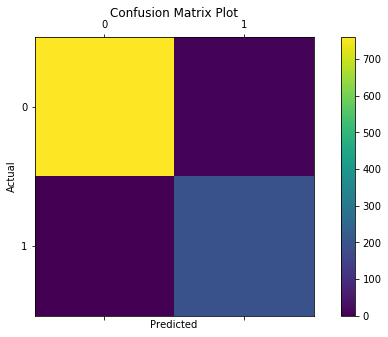

In [46]:
# Nice plot of confusion matrix
# Adjust size of confusion matrix by following code taken from StackOverflow
# https://stackoverflow.com/questions/43021762/matplotlib-how-to-change-figsize-for-matshow
plt.figure(figsize=(10,5))
plt.matshow(cm, fignum=1)

plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

## Predict whether a well-known crystallizable protein, chicken lysozyme, will crystallize or not using tripeptide frequency and Logistic Regression. 

In [47]:
# The following sequence is for the hen egg white lysozyme protein which is known to crystallize
seq = 'KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPC\
       SALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL'

In [48]:
data = [seq]

In [49]:
# Note: VERY IMPORTANT! use transform method NOT fit_transform method,
# otherwise new data will NOT BE IN CORRECT FORMAT/SHAPE
X_seq = vector_3.transform(data)
X_seq.toarray()

array([[1, 0, 0, ..., 0, 0, 0]])

In [50]:
X_seq

<1x7934 sparse matrix of type '<class 'numpy.int64'>'
	with 124 stored elements in Compressed Sparse Row format>

In [51]:
X_seq.shape

(1, 7934)

In [52]:
predict = lr.predict(X_seq)[0]
predict

1

## The Logistic Regression Model predicts lysozyme will crystallize!